In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# Download training dataset
dataset = FashionMNIST(root='data/', download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16962846.44it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273058.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5036062.01it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4554371.86it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(dataset)

60000

Label:  1


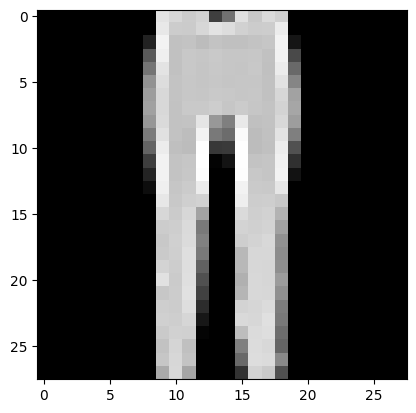

In [4]:
image,lable = dataset[106]
plt.imshow(image,cmap='gray')#cmap = colour map
print('Label: ',lable)

Label:  7


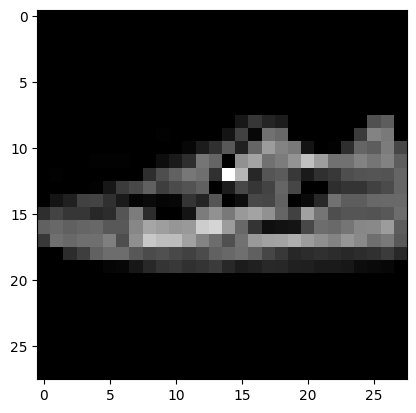

In [5]:
image,label = dataset[10001]
plt.imshow(image,cmap='gray')
print('Label: ',label)

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the `MNIST` class by passing `train=False` to the constructor.

In [6]:
test_dataset = FashionMNIST(root='data/', train=False)
len(test_dataset)

10000

###Pytorch doesn't know how to work with images so we need to transfer it into tensors

In [7]:
import torchvision.transforms as transforms

In [8]:
dataset = FashionMNIST(root='data/',train=True,transform=transforms.ToTensor())

In [9]:
img_tensor,label = dataset[10001]
img_tensor.shape,label

(torch.Size([1, 28, 28]), 7)

The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [10]:
img_tensor[0,10:15,20:25]

tensor([[0.0784, 0.0000, 0.0078, 0.1804, 0.3961],
        [0.7529, 0.6196, 0.4471, 0.4471, 0.5098],
        [0.1020, 0.1922, 0.2235, 0.3059, 0.3255],
        [0.0000, 0.0000, 0.1804, 0.2039, 0.2039],
        [0.0392, 0.1608, 0.4471, 0.3647, 0.3647]])

The values range from 0 to 1, with `0` representing black, `1` white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

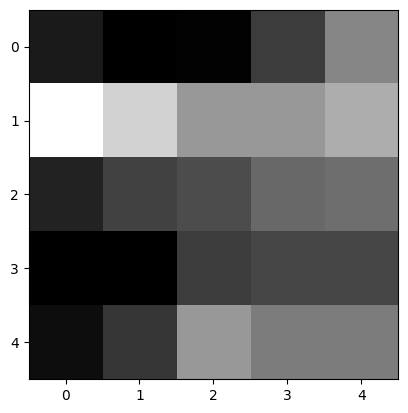

In [11]:
plt.imshow(img_tensor[0,10:15,20:25],cmap='gray')

In [12]:
torch.cuda.is_available()

True

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [13]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [14]:
batch_size = 128

In [15]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


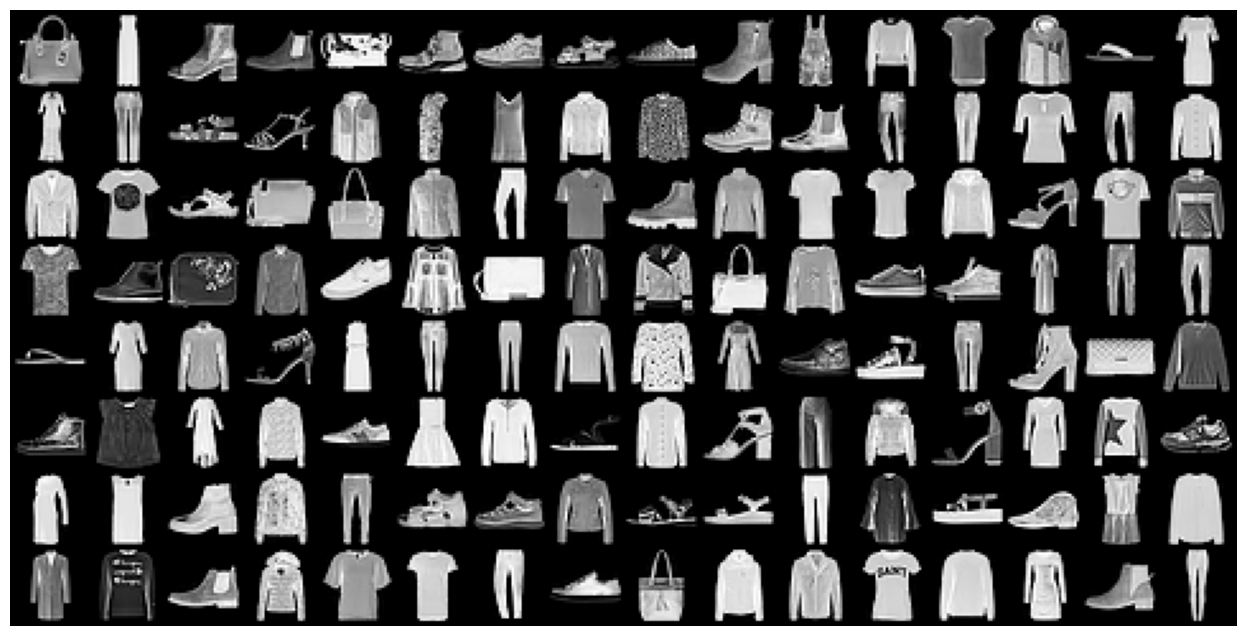

In [16]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias.

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [17]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network.

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## Training the model

In [20]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
input_size = 784
num_classes = 10

In [22]:
model = MnistModel(input_size, out_size=num_classes)

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.303412914276123, 'val_acc': 0.09189452975988388}]

In [24]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7504, val_acc: 0.6915
Epoch [1], val_loss: 0.7187, val_acc: 0.7055
Epoch [2], val_loss: 0.6695, val_acc: 0.7640
Epoch [3], val_loss: 0.8113, val_acc: 0.7322
Epoch [4], val_loss: 0.5991, val_acc: 0.7970


In [25]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4775, val_acc: 0.8315
Epoch [1], val_loss: 0.4742, val_acc: 0.8301
Epoch [2], val_loss: 0.4724, val_acc: 0.8296
Epoch [3], val_loss: 0.4700, val_acc: 0.8287
Epoch [4], val_loss: 0.4670, val_acc: 0.8286


In [26]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4718, val_acc: 0.8290
Epoch [1], val_loss: 0.4568, val_acc: 0.8322
Epoch [2], val_loss: 0.4539, val_acc: 0.8366
Epoch [3], val_loss: 0.4502, val_acc: 0.8329
Epoch [4], val_loss: 0.4499, val_acc: 0.8366


In [27]:
history = history + fit(20,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.4487, val_acc: 0.8361
Epoch [1], val_loss: 0.4494, val_acc: 0.8349
Epoch [2], val_loss: 0.4500, val_acc: 0.8354
Epoch [3], val_loss: 0.4542, val_acc: 0.8356
Epoch [4], val_loss: 0.4442, val_acc: 0.8356
Epoch [5], val_loss: 0.4455, val_acc: 0.8365
Epoch [6], val_loss: 0.4742, val_acc: 0.8240
Epoch [7], val_loss: 0.4395, val_acc: 0.8406
Epoch [8], val_loss: 0.4413, val_acc: 0.8363
Epoch [9], val_loss: 0.4251, val_acc: 0.8472
Epoch [10], val_loss: 0.4280, val_acc: 0.8454
Epoch [11], val_loss: 0.4604, val_acc: 0.8294
Epoch [12], val_loss: 0.4291, val_acc: 0.8445
Epoch [13], val_loss: 0.4463, val_acc: 0.8364
Epoch [14], val_loss: 0.4233, val_acc: 0.8447
Epoch [15], val_loss: 0.4264, val_acc: 0.8450
Epoch [16], val_loss: 0.4279, val_acc: 0.8427
Epoch [17], val_loss: 0.4178, val_acc: 0.8465
Epoch [18], val_loss: 0.5618, val_acc: 0.7914
Epoch [19], val_loss: 0.4208, val_acc: 0.8484


In [28]:
history += fit(20,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.4369, val_acc: 0.8420
Epoch [1], val_loss: 0.4264, val_acc: 0.8438
Epoch [2], val_loss: 0.4270, val_acc: 0.8442
Epoch [3], val_loss: 0.4473, val_acc: 0.8388
Epoch [4], val_loss: 0.4401, val_acc: 0.8394
Epoch [5], val_loss: 0.4214, val_acc: 0.8459
Epoch [6], val_loss: 0.5172, val_acc: 0.8138
Epoch [7], val_loss: 0.4166, val_acc: 0.8478
Epoch [8], val_loss: 0.4367, val_acc: 0.8368
Epoch [9], val_loss: 0.4472, val_acc: 0.8425
Epoch [10], val_loss: 0.4203, val_acc: 0.8476
Epoch [11], val_loss: 0.4153, val_acc: 0.8496
Epoch [12], val_loss: 0.4554, val_acc: 0.8330
Epoch [13], val_loss: 0.4162, val_acc: 0.8519
Epoch [14], val_loss: 0.4324, val_acc: 0.8406
Epoch [15], val_loss: 0.4225, val_acc: 0.8459
Epoch [16], val_loss: 0.4280, val_acc: 0.8460
Epoch [17], val_loss: 0.4320, val_acc: 0.8434
Epoch [18], val_loss: 0.4378, val_acc: 0.8423
Epoch [19], val_loss: 0.5482, val_acc: 0.8036


In [29]:
history += fit(20,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.4150, val_acc: 0.8510
Epoch [1], val_loss: 0.4444, val_acc: 0.8364
Epoch [2], val_loss: 0.4200, val_acc: 0.8449
Epoch [3], val_loss: 0.4226, val_acc: 0.8490
Epoch [4], val_loss: 0.4411, val_acc: 0.8451
Epoch [5], val_loss: 0.4125, val_acc: 0.8506
Epoch [6], val_loss: 0.4477, val_acc: 0.8374
Epoch [7], val_loss: 0.4230, val_acc: 0.8434
Epoch [8], val_loss: 0.4378, val_acc: 0.8413
Epoch [9], val_loss: 0.4218, val_acc: 0.8521
Epoch [10], val_loss: 0.4421, val_acc: 0.8407
Epoch [11], val_loss: 0.4357, val_acc: 0.8402
Epoch [12], val_loss: 0.4546, val_acc: 0.8390
Epoch [13], val_loss: 0.4124, val_acc: 0.8537
Epoch [14], val_loss: 0.4149, val_acc: 0.8515
Epoch [15], val_loss: 0.4351, val_acc: 0.8470
Epoch [16], val_loss: 0.4166, val_acc: 0.8479
Epoch [17], val_loss: 0.4178, val_acc: 0.8515
Epoch [18], val_loss: 0.4471, val_acc: 0.8448
Epoch [19], val_loss: 0.4210, val_acc: 0.8510


In [30]:
history += fit(5,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.4157, val_acc: 0.8523
Epoch [1], val_loss: 0.4247, val_acc: 0.8475
Epoch [2], val_loss: 0.4455, val_acc: 0.8399
Epoch [3], val_loss: 0.4139, val_acc: 0.8531
Epoch [4], val_loss: 0.4392, val_acc: 0.8441


In [31]:
history += fit(5,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.4364, val_acc: 0.8442
Epoch [1], val_loss: 0.4182, val_acc: 0.8496
Epoch [2], val_loss: 0.4466, val_acc: 0.8447
Epoch [3], val_loss: 0.4362, val_acc: 0.8479
Epoch [4], val_loss: 0.4162, val_acc: 0.8545


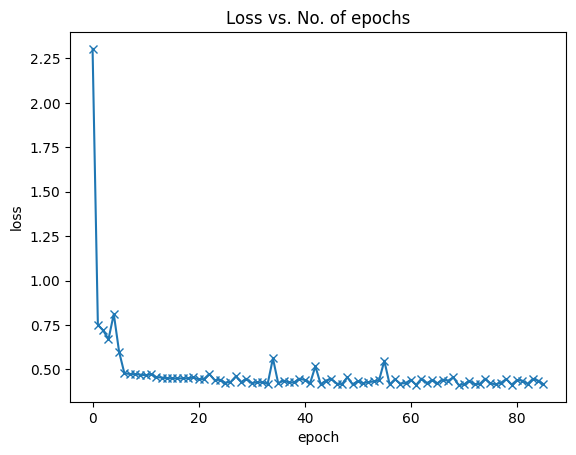

In [32]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

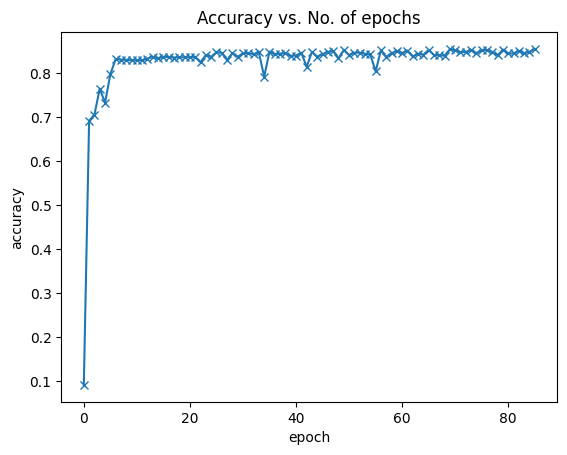

In [33]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [34]:
def predict_image(img, model):
    # Convert the PIL image to a PyTorch tensor
    img = ToTensor()(img)

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


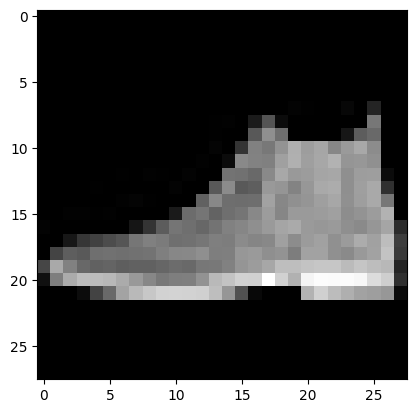

In [35]:
img, label = test_dataset[0]
plt.imshow(img, cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Trouser , Predicted: Trouser


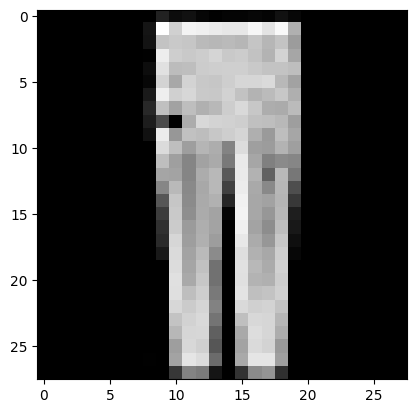

In [36]:
img, label = test_dataset[200]
plt.imshow(img, cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Sandal , Predicted: Sandal


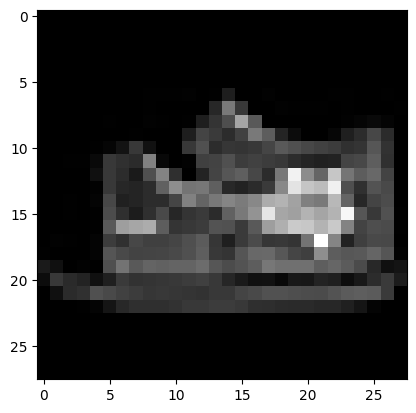

In [37]:
img, label = test_dataset[9999]
plt.imshow(img, cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Pullover , Predicted: Pullover


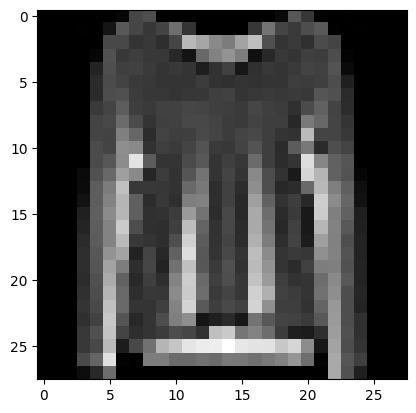

In [38]:
img, label = test_dataset[3456]
plt.imshow(img, cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])